In [16]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
from tensorflow.python.client import timeline
import numpy as np
import os
import scipy.fftpack
import matplotlib.pyplot as plt
import sys
import pickle
%matplotlib inline

from functools import partial

## set parameters

In [2]:
learning_rate = 0.001

training_epochs = 10
batch_size = 256
display_step = 1

fTimeline_profile = False

# Network Parameters
### window size for training and test
n_input = 512
n_hidden_1 = 128
n_hidden_2 = 16

examples_to_show = 5
# log directory for tensorboard
log_dir = '/tmp/tensorflow/AE_WAVE_Clustering/logs'

## create wave form data
トレーニングと評価用に、一次元の波形データを作成します。  
波形は、幾つかの周波数成分を持つサイン波信号にガウス性雑音が加えられたものです。  


In [3]:
### Segment of Wave form : Angle, in radians (2 pi rad equals 360 degrees) 
train_min, train_max = 0, 10000
test_min, test_max = train_max, 20000

resolution = 0.1

### Common Wave form
def base_wave(t):
    return np.sin(t) / 3 + 0.5 * np.sin(t*5) + 0.25 * np.sin(t*10) 
    #return t * np.sin(t)  

### Train wave
def train_time_series(t):
    if t.ndim == 1:
        noise = np.random.rand(len(t))
    else:
        noise = np.random.rand(t.shape[0], t.shape[1])
    return base_wave(t) + 0.1 * noise

### get a "n_input" length wave randomly
def train_next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (train_max - train_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = train_time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps)


def train_time_series_FFT(t):
    tmp = train_time_series(t)
    
    nFFT = t.shape[1] * 2
    blackmanWindow = np.blackman(t.shape[1])
    windowedData = blackmanWindow * tmp[:,:]
    windowedFFT = np.fft.fft(windowedData, n=nFFT)
    # 振幅スペクトル
    amp = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in windowedFFT[:,1:int(nFFT/2+1)]] 
    return np.array(amp)


def train_next_batch_FFT(batch_size, n_steps):
    ys = train_next_batch(batch_size, n_steps)
    
    nFFT = n_steps * 2
    blackmanWindow = np.blackman(n_steps)
    windowedData = blackmanWindow * ys[:,:]
    windowedFFT = np.fft.fft(windowedData, n=n_steps*2)
    # 振幅スペクトル
    amp = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in windowedFFT[:,1:int(nFFT/2+1)]] 
    return np.array(amp)



### Anomaly wave for Test wave
anomaly_start = 0.75    # Test wave全体長のおいて、anomaly_start(%)の位置から徐々にanomaly waveが出現
def anomary_wave(t):
    norm = (t - test_min) / (test_max - test_min)
    norm = norm - anomaly_start
    norm = (norm > 0.0) * norm
    return np.sin(t * 20) *  (np.exp(norm) - 1) 


### Test wave
def test_time_series(t):
    if t.ndim == 1:
        noise = np.random.rand(len(t))
    else:
        noise = np.random.rand(t.shape[0], t.shape[1]) 
    return base_wave(t) + 0.1 * noise + anomary_wave(t)

### get a "n_input" length wave randomly
def test_next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (test_max - test_min - n_steps * resolution)
    Ts = test_min + t0 + np.arange(0., n_steps + 1) * resolution
    ys = test_time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps)


def test_time_series_FFT(t):
    tmp = test_time_series(t)
    
    nFFT = t.shape[1] * 2
    blackmanWindow = np.blackman(t.shape[1])
    windowedData = blackmanWindow * tmp[:,:]
    windowedFFT = np.fft.fft(windowedData, n=nFFT)
    # 振幅スペクトル
    amp = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in windowedFFT[:,1:int(nFFT/2+1)]] 
    return np.array(amp)

def test_next_batch_FFT(batch_size, n_steps):
    ys = test_next_batch(batch_size, n_steps)
    
    nFFT = n_steps * 2
    blackmanWindow = np.blackman(n_steps)
    windowedData = blackmanWindow * ys[:,:]
    windowedFFT = np.fft.fft(windowedData, n=n_steps*2)
    # 振幅スペクトル
    amp = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in windowedFFT[:,1:int(nFFT/2+1)]] 
    return np.array(amp)

## plot test data

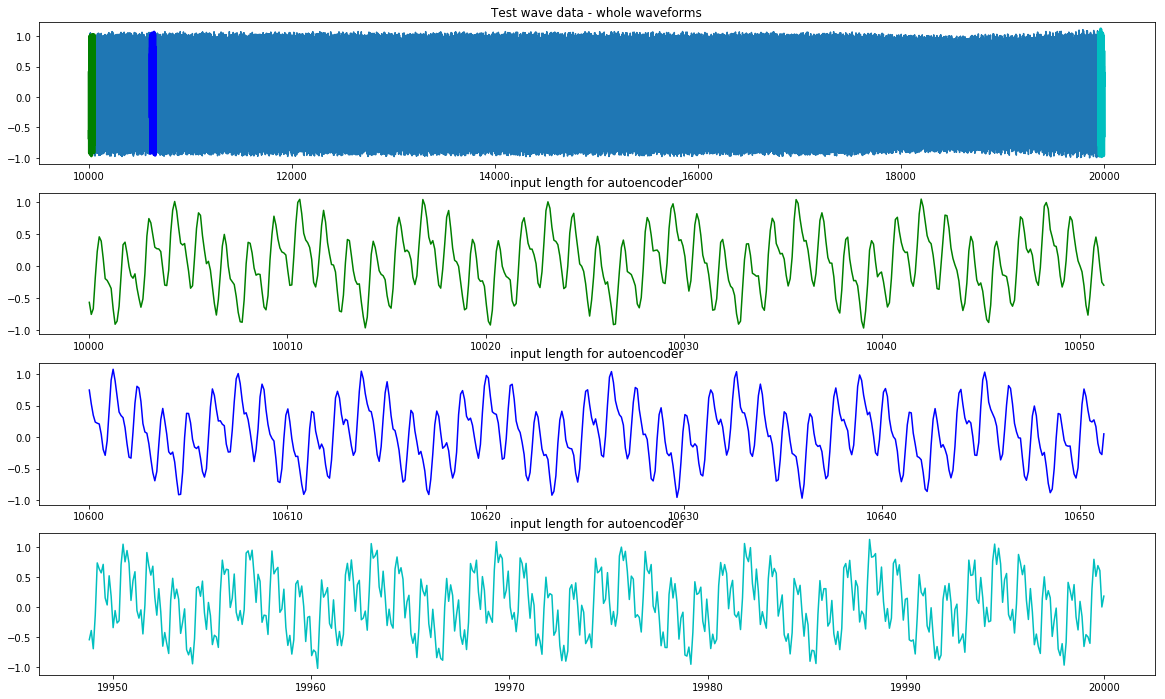

In [4]:
plot_point1 = test_min             # test_min <= plot_point <= test_max
plot_point2 = test_min + 600      # test_min <= plot_point <= test_max
plot_point3 = test_max - n_input * resolution   # test_min <= plot_point <= test_max

t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
t_instance1 = np.linspace(plot_point1, plot_point1 + resolution * (n_input + 1), n_input + 1)
t_instance2 = np.linspace(plot_point2, plot_point2 + resolution * (n_input + 1), n_input + 1)
t_instance3 = np.linspace(plot_point3, plot_point3 + resolution * (n_input + 1), n_input + 1)

wave_size = len(t)

plt.figure(figsize=(20,12))
plt.subplot(411)
plt.plot(t, test_time_series(t), label=r"whole wave")
plt.plot(t_instance1[:-1], test_time_series(t_instance1[:-1]), "g-", linewidth=3)
plt.plot(t_instance2[:-1], test_time_series(t_instance2[:-1]), "b-", linewidth=3)
plt.plot(t_instance3[:-1], test_time_series(t_instance3[:-1]), "c-", linewidth=3)
plt.title('Test wave data - whole waveforms')
#plt.xlabel('Angle, in radians')
plt.subplot(412)
plt.plot(t_instance1[:-1], test_time_series(t_instance1[:-1]), "g-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')
plt.subplot(413)
plt.plot(t_instance2[:-1], test_time_series(t_instance2[:-1]), "b-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')
plt.subplot(414)
plt.plot(t_instance3[:-1], test_time_series(t_instance3[:-1]), "c-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')

### Store values for  tensorbord 

In [5]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## 標準layer関数を作成

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [6]:
def save_summaries(func):
    def new_function(*args, **kwargs):
        layer = func(*args, **kwargs)
        layer_vars = layer.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer
    
    return new_function


#@save_summaries
def nn_layer(input_tensor, output_dim, name, activation=tf.nn.elu, l2_reg=0.0005):
    with tf.variable_scope(name):
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 

        layer = tf.layers.dense(input_tensor, output_dim, 
                                activation=activation,
                                kernel_initializer=he_init,
                                kernel_regularizer=l2_regularizer)
        
        return layer

## decoder部

In [7]:
def encoder(x):
    layer_1 = nn_layer(x, n_hidden_1, name='encoder_1')
    layer_2 = nn_layer(layer_1, n_hidden_2, name='encoder_2')
    return layer_2

## encoder部

In [8]:
def decoder(x):
    layer_1 = nn_layer(x, n_hidden_1, name='decoder_1')
    layer_2 = nn_layer(layer_1, n_input, name='decoder_2', activation=None)
    return layer_2

## Reset Graph

In [9]:
tf.reset_default_graph()

## グラフを定義

二乗和誤差を用いてロス値を計算する方法

In [10]:
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input])

# Construct model
with tf.variable_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.variable_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.variable_scope('prediction'):
    y_pred = decoder_op

# Targets (Labels) are the input data.
with tf.variable_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.variable_scope('reduce_mean'):
    #cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    cost = tf.reduce_mean(tf.square(y_true - y_pred))
tf.summary.scalar('reduce_mean', cost)


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## グラフを定義

コスト関数：シグモイド＆クロスエントロピー誤差を用いてロス値を計算する方法

一次元Wave dataの場合、こちらのロス計算法を利用すると性能が悪かったので現状は不採用

In [11]:
"""

with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input])
    
# Construct model
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = tf.nn.sigmoid(decoder_op)

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)
    cost = tf.reduce_mean(loss)
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
"""

"\n\nwith tf.variable_scope('input'):\n    X = tf.placeholder(tf.float32, [None, n_input])\n    \n# Construct model\nwith tf.name_scope('encoder_part'):\n    encoder_op = encoder(X)\n\nwith tf.name_scope('decoder_part'):\n    decoder_op = decoder(encoder_op)\n\n# Prediction\nwith tf.name_scope('prediction'):\n    y_pred = tf.nn.sigmoid(decoder_op)\n\n# Targets (Labels) are the input data.\nwith tf.name_scope('target'):\n    y_true = X\n\n# Define loss and optimizer, minimize the squared error\nwith tf.name_scope('reduce_mean'):\n    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)\n    cost = tf.reduce_mean(loss)\ntf.summary.scalar('reduce_mean', cost)\n\n\nwith tf.name_scope('train'):\n    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)\n"

## Training & Evaluation

In [12]:
# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

saver = tf.train.Saver()

## Data load

In [17]:
train_file = u'train.pickle'
if os.path.isfile(train_file) == False:
    total_batch = int(wave_size / batch_size)
    total_batch_xs = test_next_batch(wave_size, n_input)
    #ファイルに書き込み
    with open(train_file, 'wb') as f:
        pickle.dump(total_batch_xs, f)
else:
    with open(train_file, 'rb') as f:
        total_batch_xs = pickle.load(f)

Epoch: 0001 cost= 0.004873870
Epoch: 0002 cost= 0.002996163
Epoch: 0003 cost= 0.002056309
Epoch: 0004 cost= 0.001625710
Epoch: 0005 cost= 0.001364477
Epoch: 0006 cost= 0.001190100
Epoch: 0007 cost= 0.001101226
Epoch: 0008 cost= 0.001048575
Epoch: 0009 cost= 0.001012954
Epoch: 0010 cost= 0.000981034
Optimization Finished!


/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


 
*** Profile printout saved to text file 'prun0'. 


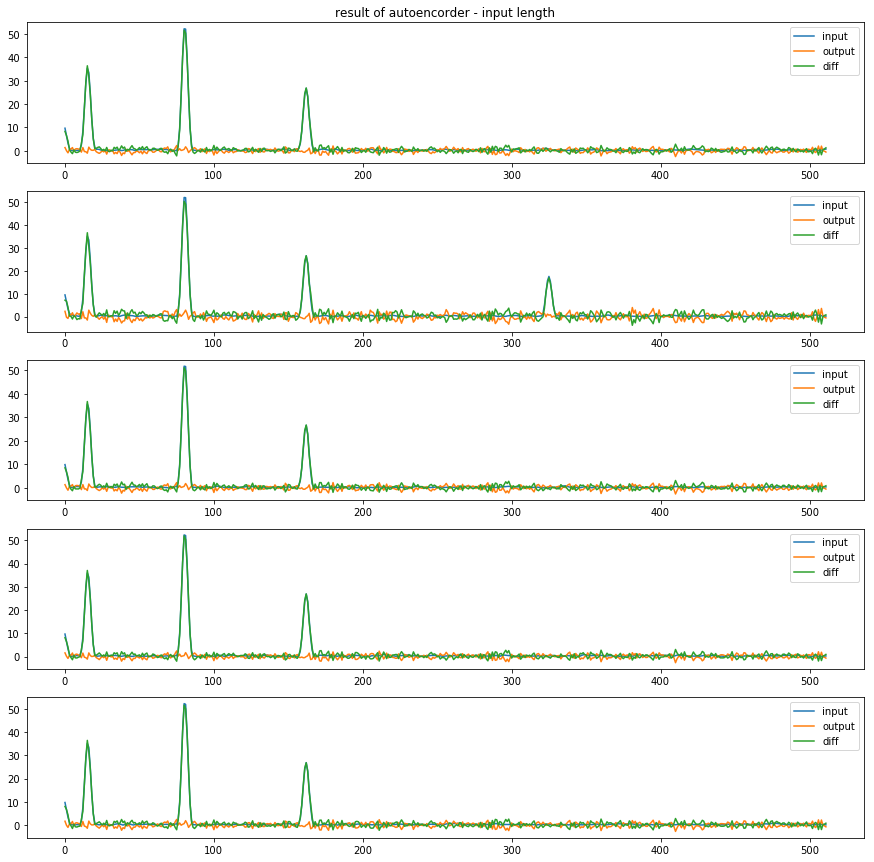

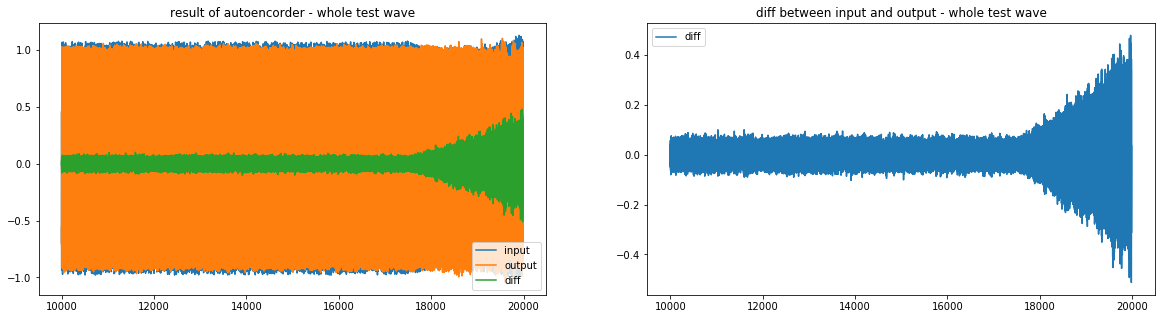

In [19]:
%%prun -s cumulative -q -l 100 -T prun0

# Launch the graph
index = 0
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/summaries/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/summaries/test')

    total_batch = int(wave_size/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        for i in range(total_batch):
            #batch_xs = test_next_batch_FFT(batch_size, n_input)
            batch_xs = total_batch_xs[batch_size * i: batch_size * (i+1)]
            if fTimeline_profile == False:
                summary, _, c = sess.run([merged, optimizer, cost], feed_dict={X: batch_xs})
            else:
                # save timeline profile 
                summary, _, c = sess.run([merged, optimizer, cost], 
                                         feed_dict={X: batch_xs}, 
                                         options=run_options, 
                                         run_metadata=run_metadata)
                step_stats = run_metadata.step_stats
                tl = timeline.Timeline(step_stats)
                # Tensorの利用メモリもshow_memory=Trueでとれるが割愛
                ctf = tl.generate_chrome_trace_format(show_memory=False, show_dataflow=True)               
                with open(log_dir + "/timeline.json", "w") as f:
                    f.write(ctf)

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            sys.stdout.flush()
        train_writer.add_run_metadata(run_metadata, 'step%d' % epoch)
        train_writer.add_summary(summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()
    saver.save(sess, log_dir + "model/my_model")

    # Plot wave form : result of autoencorder - input length
    batch_xs = batch_xs = test_next_batch_FFT(examples_to_show, n_input)
    train_encode_decode = sess.run(y_pred,
                             feed_dict={X: batch_xs})
    # Compare original images with their reconstructions
    f, a = plt.subplots(examples_to_show, 1, figsize=(15, 15))
    for i in range(examples_to_show):
        a[i].plot(batch_xs[i], label='input')
        a[i].plot(train_encode_decode[i], label='output')
        a[i].plot(batch_xs[i] - train_encode_decode[i], label='diff')
        a[i].legend()
        a[0].set_title('result of autoencorder - input length')
    f.show()
    
    # Plot wave form : result of autoencorder - whole test wave
    t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
    n_data = int(len(t) / n_input) * n_input
    x_batch = t[:n_data].reshape(-1, n_input)
    test_encode_decode = sess.run(y_pred,
                             feed_dict={X: test_time_series(x_batch)})
    
    f, a = plt.subplots(1, 2, figsize=(20, 5))
    input_wave = test_time_series(x_batch.reshape(-1,1))
    output_wave = test_encode_decode.reshape(-1,1)
    a[0].plot(t[:n_data], input_wave, label='input')
    a[0].plot(t[:n_data], output_wave, label='output')
    a[0].plot(t[:n_data], output_wave - input_wave, label='diff')
    a[0].legend()
    a[0].set_title('result of autoencorder - whole test wave')
    a[1].plot(t[:n_data], output_wave - input_wave, label='diff')
    a[1].legend()
    a[1].set_title('diff between input and output - whole test wave')
    

sess.close()

## クラスタリング

中間層の出力をTensorboardでクラスタリングしてみます。

入力：テストデータ
embeddingデータ： 中間層のデータ

結果としては、クラスタリングが上手くできませんでした。
理由としては、トレーニングデータのみで学習していることが考えられます。
トレーニングデータと異なる特徴のテストデータを入力とし、中間層を取り出したとしても、
表現できるのはトレーニングデータで学習した特徴のみが中間層で表現されているためだと思われます。

In [12]:
import os
from tensorflow.contrib.tensorboard.plugins import projector

In [14]:

# Plot wave form : result of autoencorder - whole test wave
t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
n_data = int(len(t) / n_input) * n_input
x_batch = t[:n_data].reshape(-1, n_input)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, log_dir + "model/my_model") # not shown
    hidden = sess.run(encoder_op,
                      feed_dict={X: test_time_series_FFT(x_batch)})

INFO:tensorflow:Restoring parameters from /tmp/tensorflow/AE_WAVE_Clustering/logsmodel/my_model


In [15]:
tmp = test_time_series_FFT(x_batch)

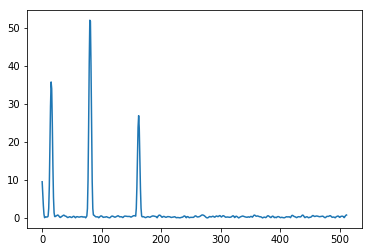

In [16]:
plt.plot(tmp[20])

### メタデータファイルの作成

メタデータファイルは、  
* 最初の行にカラム名を記述  
* メタ情報を2行目以降に記述  

例えば、MNISTの画像のメタデータを作る場合は、以下のように最初のカラムにインデックス、次のカラムにラベル名（数字）を指定します。

In [17]:
# 
#LOG_DIR = "/tmp/tensorflow/autoencoder_WAVE/logs"

# recreate log directory
if tf.gfile.Exists(log_dir + '/projector'):
    tf.gfile.DeleteRecursively(log_dir + '/projector')
tf.gfile.MakeDirs(log_dir + '/projector')

In [18]:
n_class = 10
n_cluster = hidden.shape[0]
n_each_class_data = int(n_cluster / n_class + 1)

with open(os.path.join(log_dir, 'projector/metadata.tsv'),'w') as f:
    #f.write("Index\tLabel\n")
    for i in np.arange(n_cluster):
        label = int(i / n_each_class_data)
        f.write('{}\n'.format(label))

### クラスタ用のembeddingを保存

In [19]:
xs = tf.stack(hidden, axis=0)

with tf.variable_scope('hidden_embedding'):
    embedding_var = tf.Variable(xs, trainable=False, name='embedding')


summary_writer = tf.summary.FileWriter(os.path.join(log_dir, 'projector'), sess.graph)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# metadata 
embedding.metadata_path = os.path.join(log_dir, 'projector/metadata.tsv')

# stripe 
#embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
#embedding.sprite.single_image_dim.extend([28,28])

projector.visualize_embeddings(summary_writer, config)


#sess = tf.InteractiveSession()

# initialize "embedding_ver"
init = tf.variables_initializer([embedding_var])

with tf.Session() as sess:
    sess.run(init)
    # specify variable to save 
    saver = tf.train.Saver([embedding_var])
    # save variables 
    saver.save(sess, os.path.join(log_dir, "projector/model.ckpt"), global_step=n_data)

## Tensorboard 起動

tensorboard --logdir=/tmp/tensorflow/tensorboard

In [24]:
!tensorboard --logdir=/tmp/tensorflow/AE_WAVE_Clustering

Starting TensorBoard b'54' at http://shinya-no-MacBook-Pro.local:6006
(Press CTRL+C to quit)
^C
